Alright! I'm gonna try to get some info about my Spotify playlists.

If you don't want to see all the beautiful plots I made you can go down straight to the Conclusions section.

[Conclusions](#Conclusions)

In [84]:
%matplotlib inline

import os
import my_spotify_credentials as credentials
import numpy as np
import pandas as pd
import ujson
import spotipy
import spotipy.util
import seaborn as sns
from bokeh.charts import Histogram, Scatter, Donut, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh import palettes

Please note that I had to configure my Spotify Dev account credentials (https://spotipy.readthedocs.io/en/latest/#authorization-code-flow) in order to fetch some of the following requests.

Setting up the scope (https://developer.spotify.com/web-api/using-scopes/), the username and then request the songs in my library filtering some fields (I'm only gonna work with the following info: song names, artists, song duration, the date I added that song to my library and its popularity).

In [85]:
os.environ["SPOTIPY_CLIENT_ID"] = credentials.SPOTIPY_CLIENT_ID
os.environ["SPOTIPY_CLIENT_SECRET"] = credentials.SPOTIPY_CLIENT_SECRET
os.environ["SPOTIPY_REDIRECT_URI"] = credentials.SPOTIPY_REDIRECT_URI

scope = 'user-library-read'
username = 'jose.vicente'

token = spotipy.util.prompt_for_user_token(username, scope)

if token:
    spotipy_obj = spotipy.Spotify(auth=token)
    saved_tracks_resp = spotipy_obj.current_user_saved_tracks(limit=50)
else:
    print('Couldn\'t get token for that username')
    
number_of_tracks = saved_tracks_resp['total']
print('%d tracks' % number_of_tracks)

def save_only_some_fields(track_response):
    return {        
        'id': str(track_response['track']['id']),
        'name': str(track_response['track']['name']),
        'artists': [artist['name'] for artist in track_response['track']['artists']],
        'duration_ms': track_response['track']['duration_ms'],
        'popularity': track_response['track']['popularity'],
        'added_at': track_response['added_at']
    }

tracks = [save_only_some_fields(track) for track in saved_tracks_resp['items']]

while saved_tracks_resp['next']:
    saved_tracks_resp = spotipy_obj.next(saved_tracks_resp)
    tracks.extend([save_only_some_fields(track) for track in saved_tracks_resp['items']])

509 tracks


Let's modify the data collected to work more easily with it.

In [86]:
tracks_df = pd.DataFrame(tracks)
pd.set_option('display.max_rows', len(tracks))

In case there are more than one artists, I only care for the first one. I'm gonna transform the length to seconds.

In [87]:
#pd.reset_option('display.max_rows')

tracks_df['artists'] = tracks_df['artists'].apply(lambda artists: artists[0])
tracks_df['duration_ms'] = tracks_df['duration_ms'].apply(lambda duration: duration/1000)

tracks_df = tracks_df.rename(columns = {'duration_ms':'duration_s'})

Let's make some plots, but first, let's explain (copy - paste) some concepts.

* Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

* Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

* The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

* Valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

* Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [88]:
audio_features = {}

for idd in tracks_df['id'].tolist():
    audio_features[idd] = spotipy_obj.audio_features(idd)[0]
    
tracks_df['acousticness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['acousticness'])
tracks_df['speechiness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['speechiness'])
tracks_df['key'] = tracks_df['id'].apply(lambda idd: str(audio_features[idd]['key']))
tracks_df['liveness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['liveness'])
tracks_df['instrumentalness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['instrumentalness'])
tracks_df['energy'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['energy'])
tracks_df['tempo'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['tempo'])
tracks_df['time_signature'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['time_signature'])
tracks_df['loudness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['loudness'])
tracks_df['danceability'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['danceability'])
tracks_df['valence'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['valence'])

In [89]:
output_notebook()

show(Histogram(tracks_df['popularity'], title='Tracks popularity', bins=25, density=False, plot_width=800))

show(Histogram(tracks_df[tracks_df['duration_s'] < 700]['duration_s'], 
               title='Tracks length (Tubular Bells removed)', density=False, plot_width=800))

show(Scatter(tracks_df, x='valence', y='danceability', 
             title='danceability vs valence', color='navy', plot_width=800))

show(Scatter(tracks_df, x='energy', y='loudness', 
             title='loudness vs energy', color='navy', plot_width=800))

show(Scatter(tracks_df, x='energy', y='valence', 
             title='valence vs energy', color='navy', plot_width=800))

# sns.plt.figure(figsize=(15, 10))
# sns.pairplot(tracks_df)
# sns.plt.show()

Loading BokehJS ...

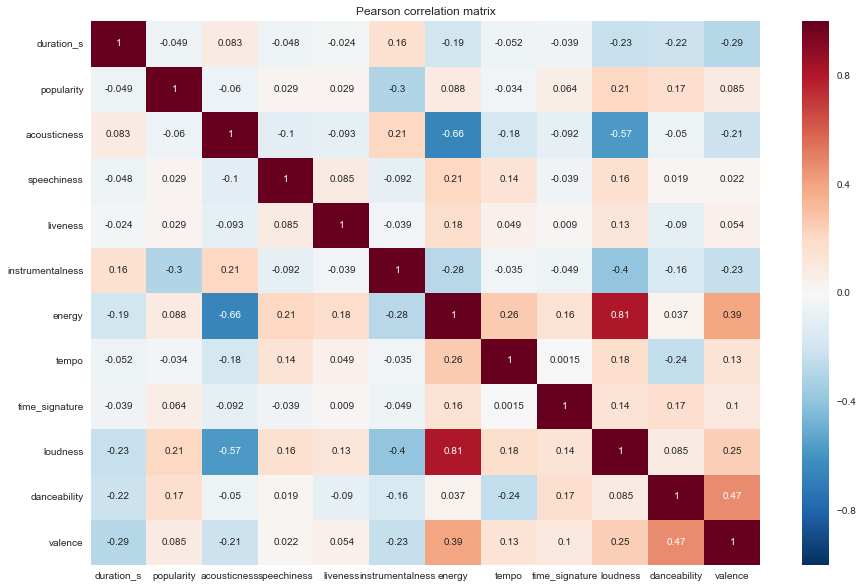

In [90]:
sns.plt.figure(figsize=(15, 10))
corr = tracks_df.corr()
sns.heatmap(corr, annot=True).set_title('Pearson correlation matrix')
sns.plt.show()

In [91]:
artists_songs_df = tracks_df['artists'].value_counts()[:15]

p = Donut(artists_songs_df, plot_width=850, plot_height=800,
           color=palettes.RdBu9, title='Number of tracks by artist')

show(p)

Number of tracks by artist

In [92]:
tracks_df['artists'].value_counts()[:40]

Oasis                                 33
The Vaccines                          19
Coldplay                              15
Metallica                             15
Love of Lesbian                       13
Nirvana                               12
The Smiths                             9
Los Punsetes                           9
David Bowie                            8
Queen                                  7
Green Day                              7
Sia                                    7
Ramones                                7
Foo Fighters                           7
Ramin Djawadi                          7
Linkin Park                            6
Kygo                                   6
Two Door Cinema Club                   6
Noel Gallagher's High Flying Birds     5
Augustines                             5
Mike Oldfield                          5
The Animals                            5
OneRepublic                            5
The Chainsmokers                       4
Johnny Cash     

Some stats about my songs

In [93]:
first_describe = tracks_df.describe()
first_describe.loc[['mean','std','50%','min','max'],:]

,duration_s,popularity,acousticness,speechiness,liveness,instrumentalness,energy,tempo,time_signature,loudness,danceability,valence
mean,251.074825,49.667976,0.156592,0.060514,0.209297,0.116754,0.721740,125.402367,3.950884,-7.141442,0.510059,0.494251
std,99.470301,22.152073,0.244579,0.051078,0.176660,0.259723,0.211626,28.030906,0.265363,3.704470,0.153271,0.248161
50%,236.001000,53.000000,0.031000,0.042100,0.134000,0.000633,0.773000,122.396000,4.000000,-6.258000,0.514000,0.498000
min,68.720000,0.000000,0.000001,0.024300,0.025900,0.000000,0.011200,68.560000,1.000000,-27.908000,0.069500,0.033100
max,1561.133000,95.000000,0.993000,0.375000,0.980000,0.967000,0.988000,204.397000,5.000000,-1.634000,0.969000,0.965000


In [94]:
print('''
The median value of my songs popularity is %.2f and the median value of my songs length is %f minutes.

The longest track lasts %f minutes and the shortest one lasts %f minutes.
''' % (first_describe['popularity']['50%'], first_describe['duration_s']['50%']/60, 
       first_describe['duration_s']['max']/60, first_describe['duration_s']['min']/60))


The median value of my songs popularity is 53.00 and the median value of my songs length is 3.933350 minutes.

The longest track lasts 26.018883 minutes and the shortest one lasts 1.145333 minutes.



The following cells show the longest song and the shortest song:

In [95]:
tracks_df.iloc[ tracks_df['duration_s'].idxmax() ][['artists','name']]

artists            Mike Oldfield
name       Tubular Bells - Pt. I
Name: 163, dtype: object

In [96]:
tracks_df.iloc[ tracks_df['duration_s'].idxmin() ][['artists','name']]

artists    The Hives
name        Come On!
Name: 367, dtype: object

Popularity ranking (songs' popularity vary over the time so this ranking may be different everytime this notebook is executed).

In [97]:
tracks_df[['added_at','name', 'artists', 'popularity']].sort_values('popularity', ascending=False)[:40]

,added_at,name,artists,popularity
26,2017-09-23T12:42:55Z,Unforgettable,French Montana,95
88,2017-06-23T09:25:40Z,Swalla (feat. Nicki Minaj & Ty Dolla $ign),Jason Derulo,89
144,2017-03-05T18:59:24Z,It Ain't Me (with Selena Gomez),Kygo,86
32,2017-08-30T14:35:16Z,Believer,Imagine Dragons,86
40,2017-08-22T18:26:47Z,Feels,Calvin Harris,84
442,2016-04-24T15:46:54Z,The Scientist,Coldplay,84
60,2017-07-22T14:12:35Z,In The End,Linkin Park,84
129,2017-03-11T19:48:56Z,Something Just Like This,The Chainsmokers,84
360,2016-06-19T12:39:33Z,Don't Let Me Down,The Chainsmokers,84
279,2016-11-17T11:33:38Z,In the Name of Love,Martin Garrix,83


Some boxplots to have a better knowledge of my songs popularity and duration

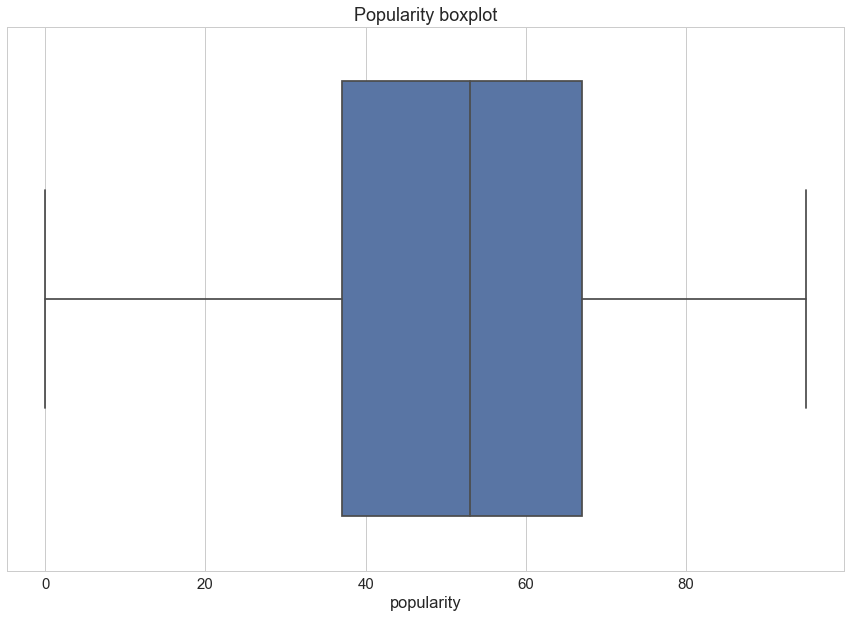

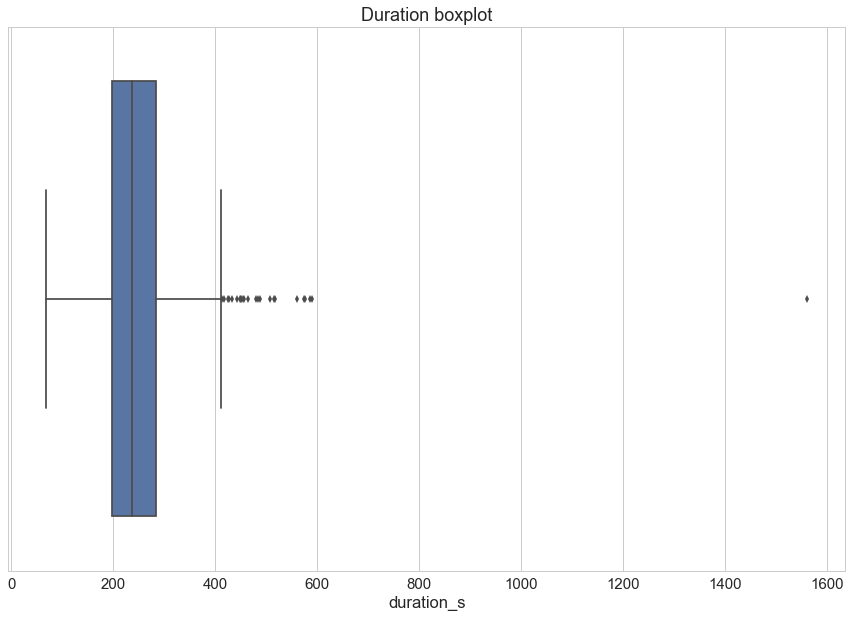

In [98]:
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['popularity']).set_title('Popularity boxplot')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['duration_s']).set_title('Duration boxplot')
sns.plt.show()

In [99]:
def plot_time_series(col_name, title, rolling_window_days):
    daily_series = pd.Series(data=np.array(tracks_df[col_name]), 
                                      name=col_name, 
                                      index=tracks_df['added_at']).sort_index()

    (daily_series.rolling(window = rolling_window_days)
     .mean()
     .plot(figsize=(30, 10))
     .set(xlabel='date (by day)', ylabel=col_name, title=title))

    sns.plt.show()    

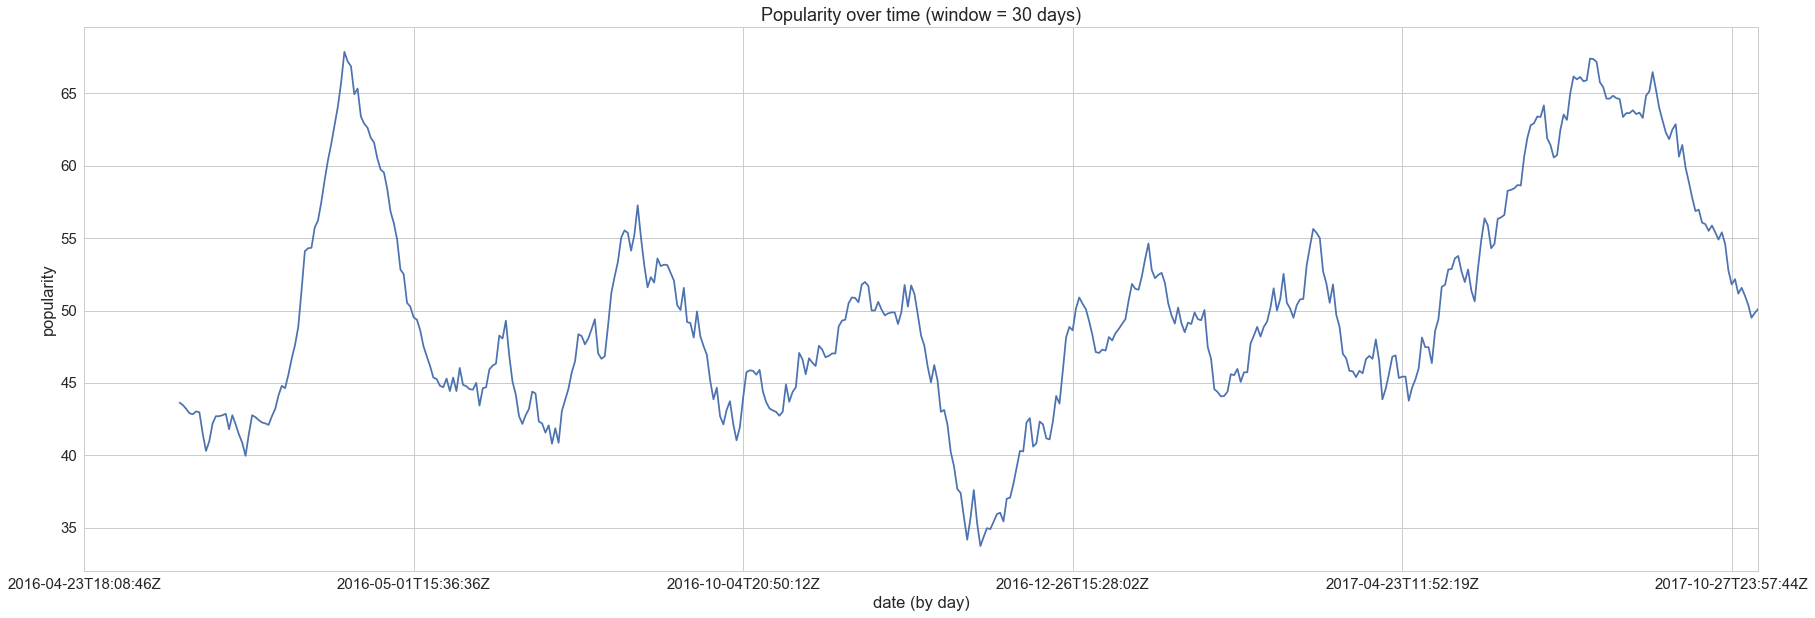

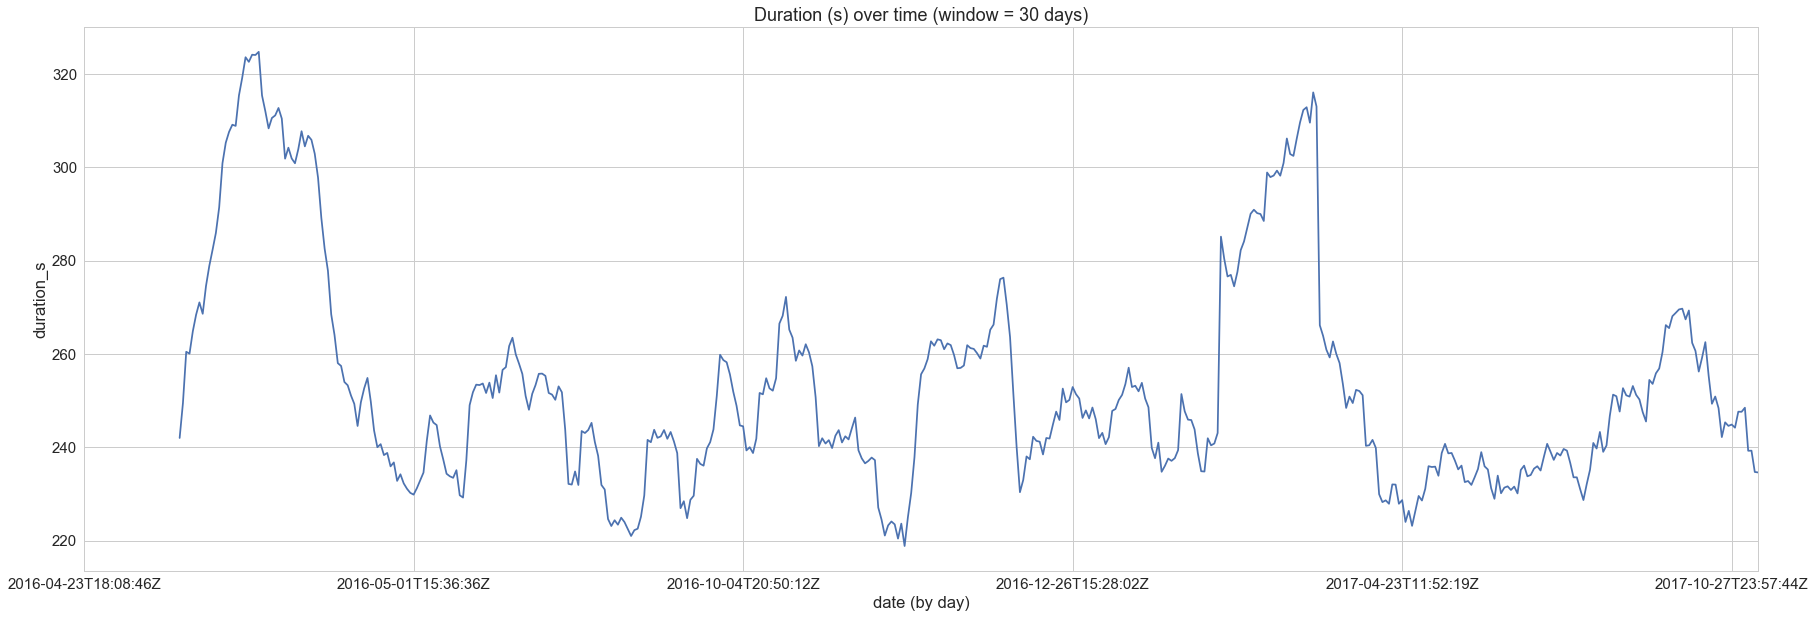

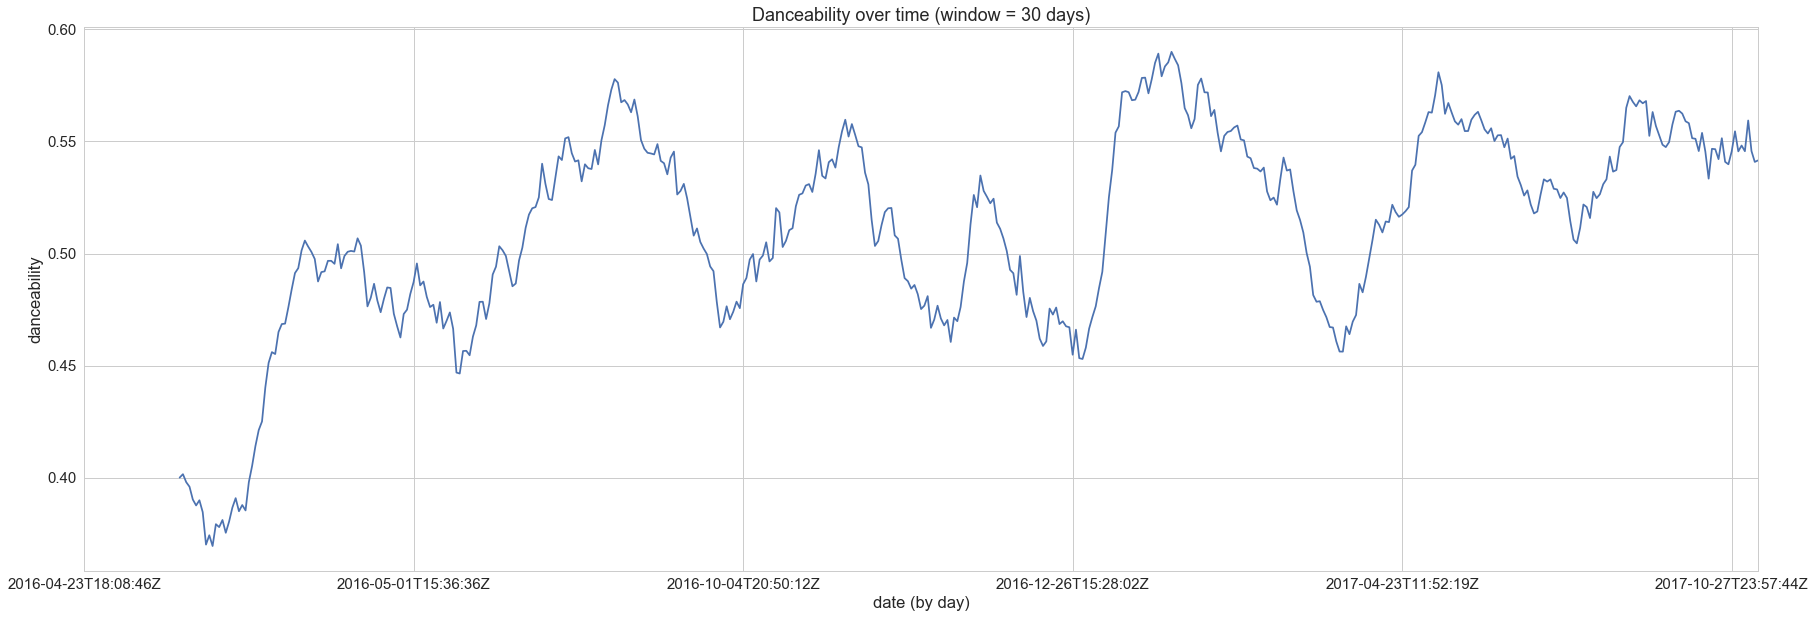

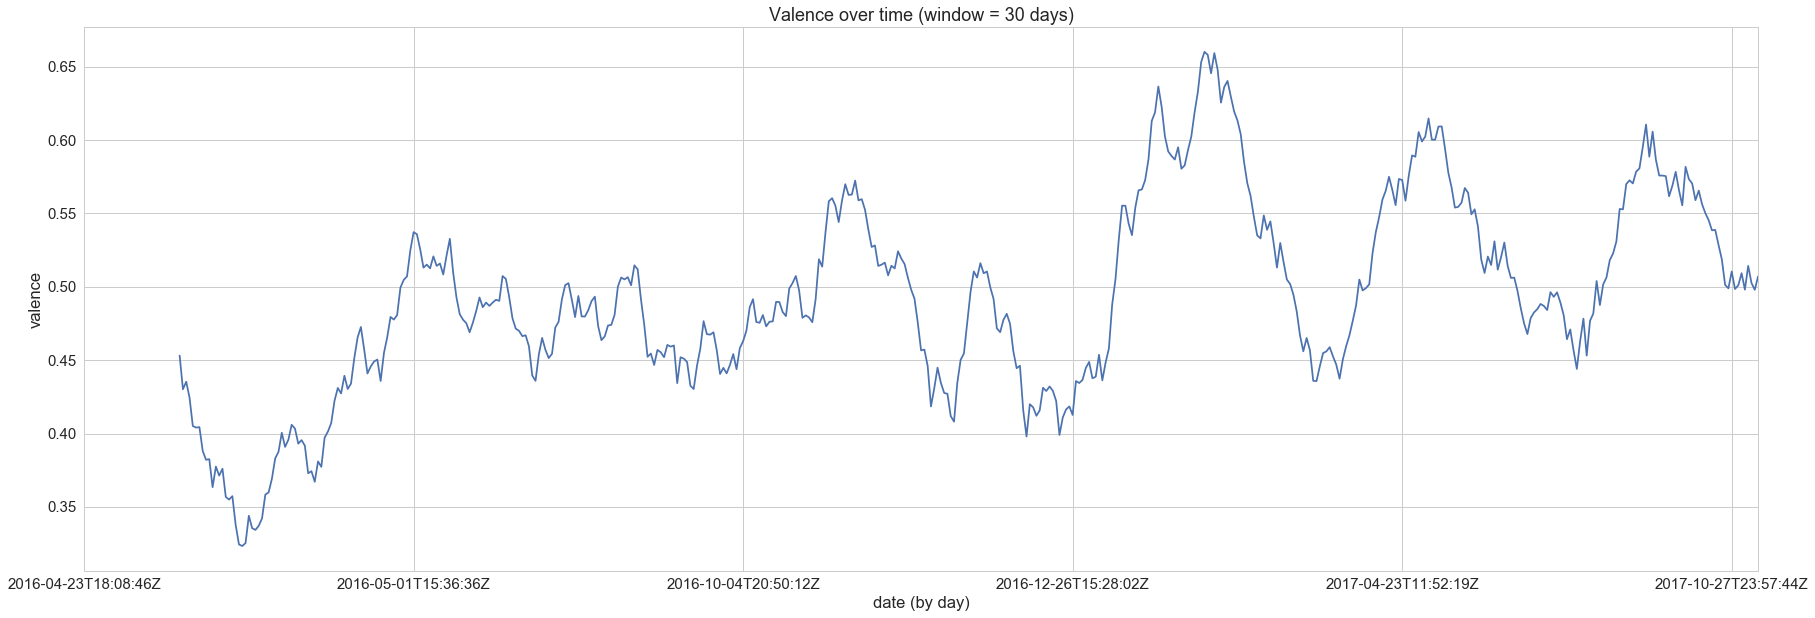

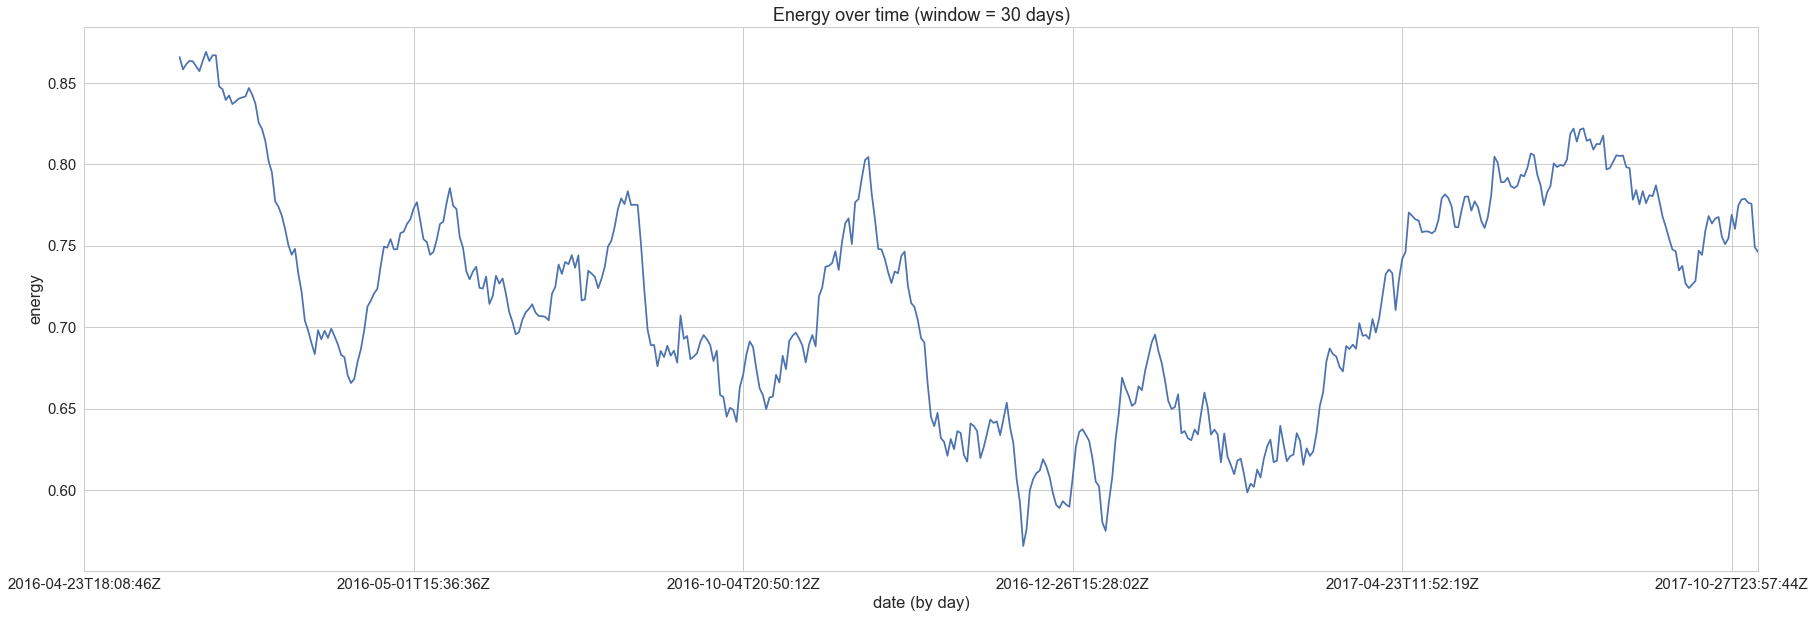

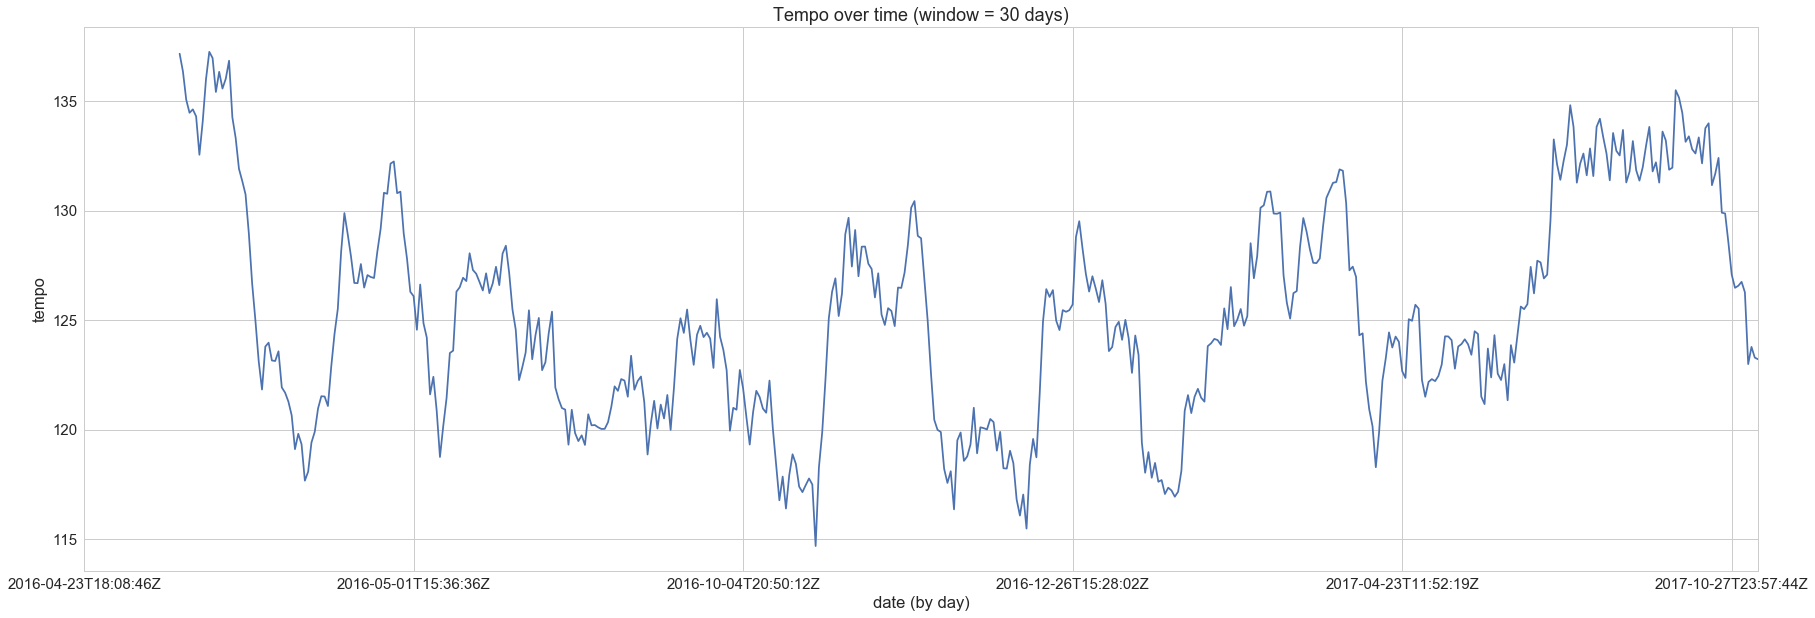

In [100]:
plot_time_series('popularity', 'Popularity over time (window = 30 days)', 30)
plot_time_series('duration_s', 'Duration (s) over time (window = 30 days)', 30)
plot_time_series('danceability', 'Danceability over time (window = 30 days)', 30)
plot_time_series('valence', 'Valence over time (window = 30 days)', 30)
plot_time_series('energy', 'Energy over time (window = 30 days)', 30)
plot_time_series('tempo', 'Tempo over time (window = 30 days)', 30)

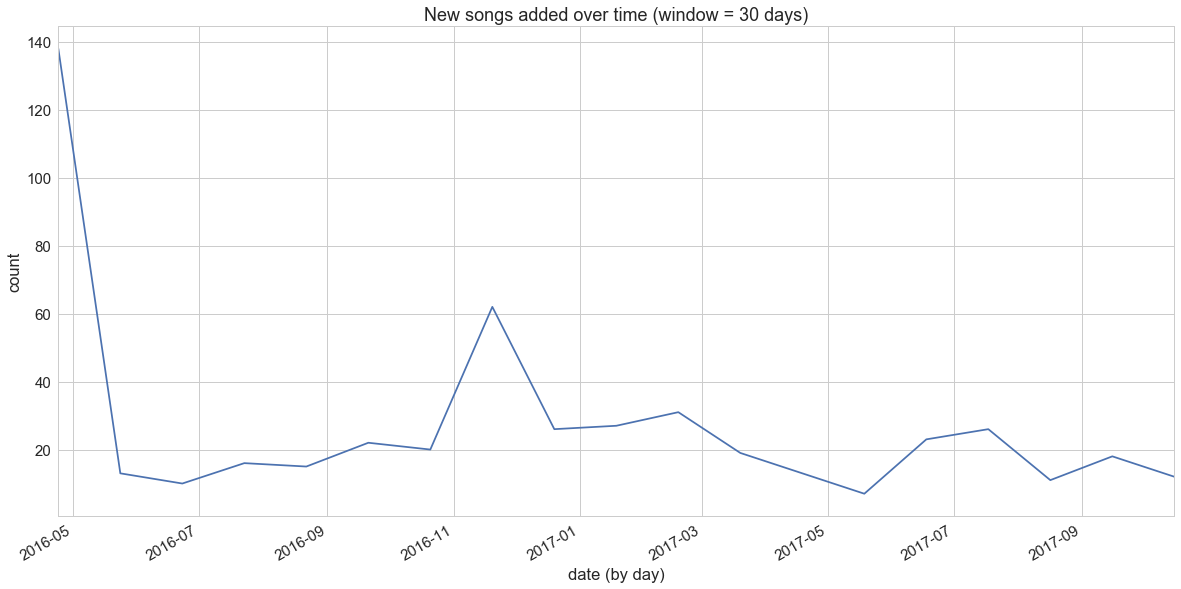

In [101]:
aux = tracks_df.copy()
aux['added_at'] =  pd.to_datetime(aux['added_at'], format='%Y-%m-%d %H:%M:%S')

songs_added_in_window = (aux.groupby([pd.Grouper(freq='30D', key='added_at'), 'id'])
 .size().reset_index(name='count').groupby('added_at').count()['count'])



(songs_added_in_window
 .plot(figsize=(20, 10))
 .set(xlabel='date (by day)', ylabel='count', title='New songs added over time (window = 30 days)'))

sns.plt.show() 

In [102]:
def get_genres(artist, spotipy_obj):
    response = spotipy_obj.search(q='artist:' + artist, type='artist')['artists']['items']
    return response[0]['genres'] if response else []

tracks_df['genres'] = tracks_df['artists'].apply(lambda artist: get_genres(artist, spotipy_obj))

In [103]:
genres = []

for gnrs in tracks_df['genres'].tolist():
    genres.extend(gnrs)
    
genres_df = pd.DataFrame(genres, columns=['genre'])

Genres ranking

In [104]:
genres_df['genre'].value_counts()[:40]

rock                 192
modern rock          142
permanent wave       123
alternative rock     120
indie rock           110
classic rock         101
pop                   81
album rock            77
britpop               64
hard rock             62
mellow gold           60
soft rock             55
indie pop             53
garage rock           49
alternative metal     48
indietronica          43
pop christmas         43
dance pop             39
dance rock            38
new wave              37
tropical house        36
edm                   36
singer-songwriter     36
art rock              35
pop rock              34
post-grunge           33
spanish indie pop     32
psychedelic rock      29
punk                  29
alt-indie rock        28
metal                 27
nu metal              27
alternative dance     27
blues-rock            26
heavy christmas       26
folk rock             25
protopunk             25
glam rock             24
spanish pop           23
new rave              23


Some histograms about the info retrieved previously

In [105]:
show(Histogram(tracks_df['valence'], title='Tracks valence (1 = happy, 0 = sad)', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['danceability'], title='Danceability', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['loudness'], title='Loudness', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['tempo'], title='Tempo', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['energy'], title='Energy', bins=50, density=False, plot_width=800))

In [106]:
pitch_classes = ['C/Do', 'C#/Do sost.', 'D/Re', 'D/Re sost.', 'E/Mi', 'F/Fa', 'F#/Fa sost.', 'G/Sol', 'G#/Sol sost.', 'A/La', 'A#/La sost.', 'B/Si']

tracks_df['key'].replace([str(i) for i in list(range(0, 12))], pitch_classes, inplace=True)

https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes


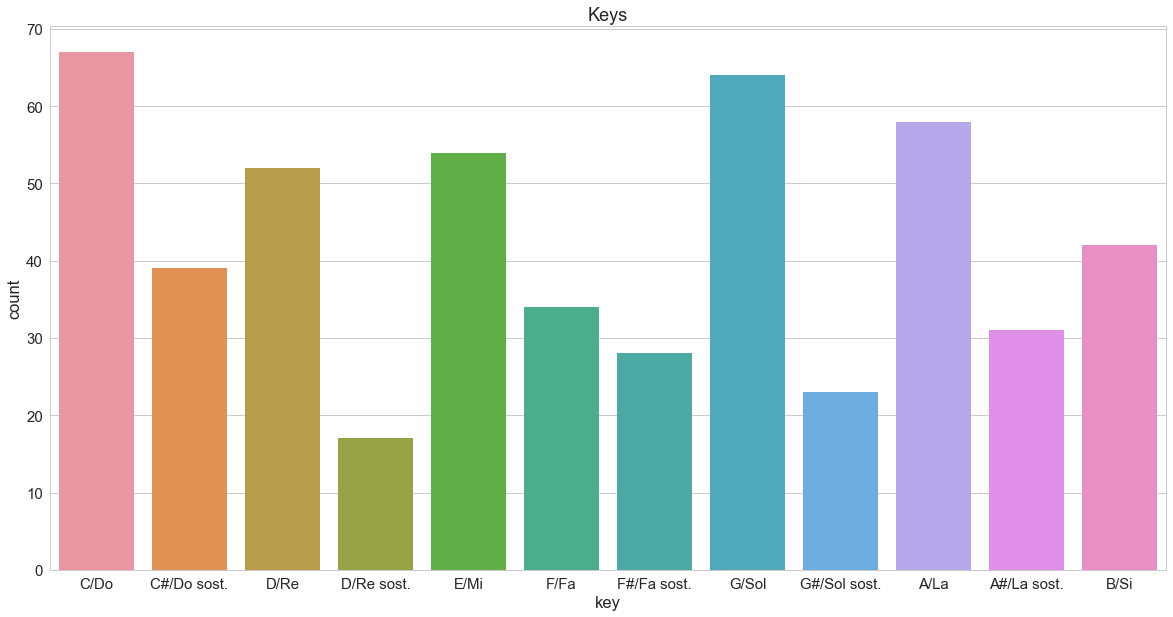

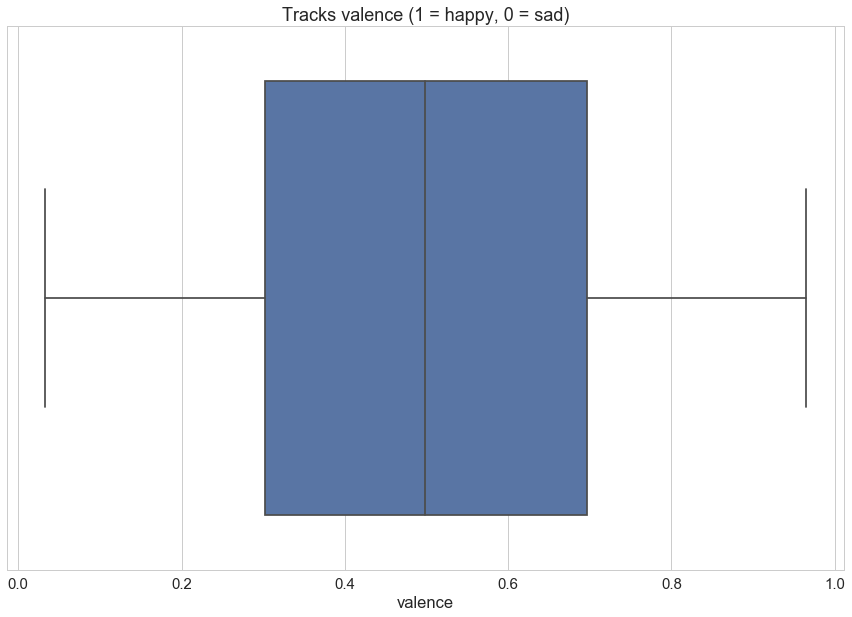

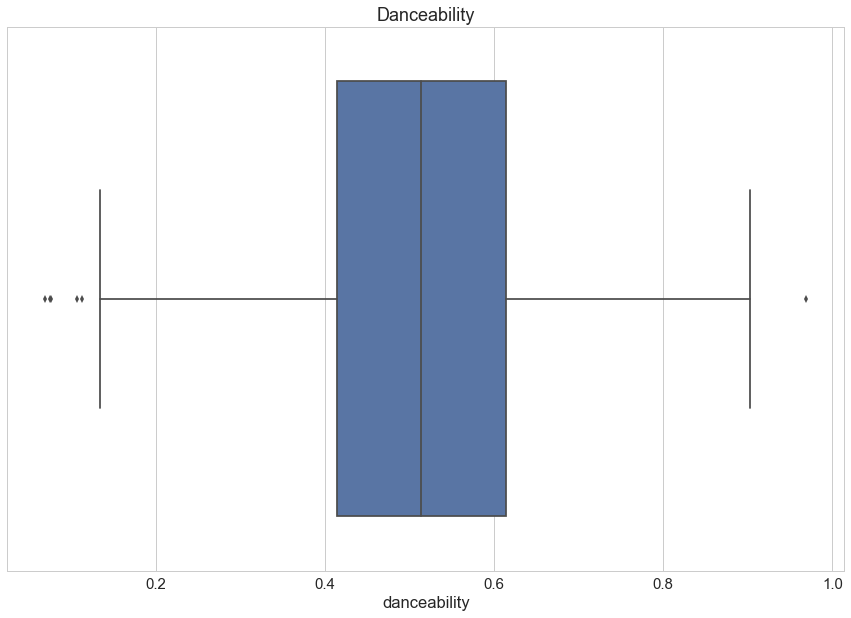

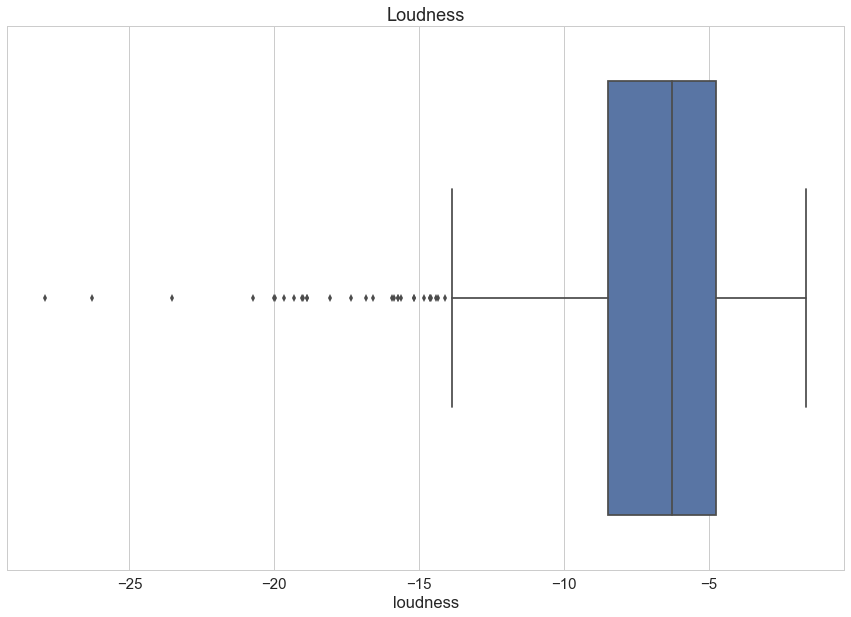

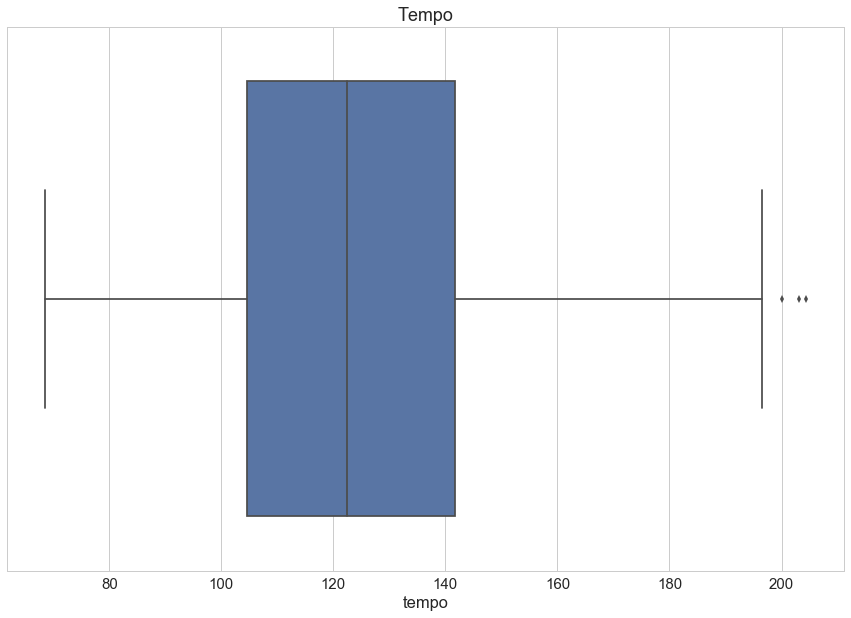

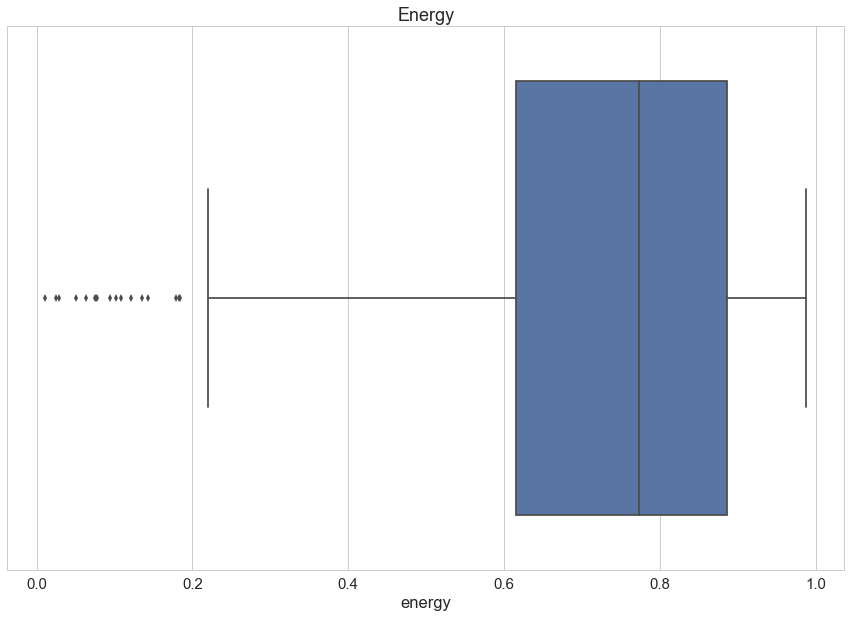

In [107]:
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

print('https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes')
sns.plt.figure(figsize=(20, 10))
(sns.countplot(x=tracks_df['key'], order=pitch_classes)
.set_title('Keys'))
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['valence']).set_title('Tracks valence (1 = happy, 0 = sad)')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['danceability']).set_title('Danceability')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['loudness']).set_title('Loudness')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['tempo']).set_title('Tempo')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['energy']).set_title('Energy')
sns.plt.show()

In [108]:
second_describe = tracks_df[['energy', 'tempo', 'loudness', 'danceability', 'valence']].describe()
second_describe.loc[['mean','std','50%','min','max'],:]

,energy,tempo,loudness,danceability,valence
mean,0.721740,125.402367,-7.141442,0.510059,0.494251
std,0.211626,28.030906,3.704470,0.153271,0.248161
50%,0.773000,122.396000,-6.258000,0.514000,0.498000
min,0.011200,68.560000,-27.908000,0.069500,0.033100
max,0.988000,204.397000,-1.634000,0.969000,0.965000


Songs with most and least energy:

In [109]:
print(tracks_df.iloc[ tracks_df['energy'].idxmax() ][['artists','name', 'energy']])
print()
print(tracks_df.iloc[ tracks_df['energy'].idxmin() ][['artists','name', 'energy']])

artists         Green Day
name       American Idiot
energy              0.988
Name: 80, dtype: object

artists                                 Ludwig van Beethoven
name       Symphony No. 7 in A Major, Op. 92: II. Allegretto
energy                                                0.0112
Name: 315, dtype: object


Songs with most and least valence:

In [110]:
print(tracks_df.iloc[ tracks_df['valence'].idxmax() ][['artists','name', 'valence']])
print()
print(tracks_df.iloc[ tracks_df['valence'].idxmin() ][['artists','name', 'valence']])

artists          Cocoon
name       I Can't Wait
valence           0.965
Name: 194, dtype: object

artists       Vitamin String Quartet
name       Motion Picture Soundtrack
valence                       0.0331
Name: 225, dtype: object


The songs with most and least tempo:

In [111]:
print(tracks_df.iloc[ tracks_df['tempo'].idxmax() ][['artists','name', 'tempo']])
print()
print(tracks_df.iloc[ tracks_df['tempo'].idxmin() ][['artists','name', 'tempo']])

artists         Joan Jett
name       Bad Reputation
tempo             204.397
Name: 217, dtype: object

artists                                 Ludwig van Beethoven
name       Symphony No. 7 in A Major, Op. 92: II. Allegretto
tempo                                                  68.56
Name: 315, dtype: object


The most and the least danceable songs:

In [112]:
print(tracks_df.iloc[ tracks_df['danceability'].idxmax() ][['artists','name', 'danceability']])
print()
print(tracks_df.iloc[ tracks_df['danceability'].idxmin() ][['artists','name', 'danceability']])

artists         Sexual Harrassment
name                I Need A Freak
danceability                 0.969
Name: 236, dtype: object

artists            Vitamin String Quartet
name            Motion Picture Soundtrack
danceability                       0.0695
Name: 225, dtype: object


Here are the loudest and the lest loud songs:

In [113]:
print(tracks_df.iloc[ tracks_df['loudness'].idxmax() ][['artists','name', 'loudness']])
print()
print(tracks_df.iloc[ tracks_df['loudness'].idxmin() ][['artists','name', 'loudness']])

artists             Oasis
name        Morning Glory
loudness           -1.634
Name: 481, dtype: object

artists                                  Ludwig van Beethoven
name        Symphony No. 7 in A Major, Op. 92: II. Allegretto
loudness                                              -27.908
Name: 315, dtype: object


Songs that match or are close to the energy median value:

In [114]:
def sorted_diffed_values(constant, df, field, n_first):
    return df.iloc[(df[field]-constant).abs().argsort()][['artists','name', field]][:n_first]    

In [115]:
sorted_diffed_values(float(format(second_describe['energy']['50%'], '.3f')), tracks_df, 'energy', 5)

,artists,name,energy
457,Nirvana,The Man Who Sold The World,0.773
362,Seeb,Breathe,0.773
8,Oingo Boingo,Just Another Day,0.773
451,David Bowie,Heroes - 1999 Remastered Version,0.774
261,Vampire Weekend,Holiday,0.775


Songs that match or are close to the tempo median value:

In [116]:
sorted_diffed_values(second_describe['tempo']['50%'], tracks_df, 'tempo', 5)

,artists,name,tempo
171,Johnny Cash,Cocaine Blues - Live,122.396
96,Bruce Springsteen,Born in the U.S.A.,122.093
392,Love of Lesbian,La noche eterna,122.035
351,Kungs,This Girl - Kungs Vs. Cookin' On 3 Burners,121.969
436,OneRepublic,Counting Stars,121.941


Songs that match or are close to the danceability median value:

In [117]:
sorted_diffed_values(float(format(second_describe['danceability']['50%'], '.2f')), tracks_df, 'danceability', 5)

,artists,name,danceability
402,The Vaccines,Panic Attack,0.510
55,Linkin Park,Leave Out All The Rest,0.509
501,The Vaccines,Give Me a Sign,0.511
464,Metallica,Whiskey In The Jar,0.511
188,Miles Kane,Come Closer,0.511


Songs that match or are close to the valence median value:

In [118]:
sorted_diffed_values(float(format(second_describe['valence']['50%'], '.2f')), tracks_df, 'valence', 5)

,artists,name,valence
144,Kygo,It Ain't Me (with Selena Gomez),0.500
351,Kungs,This Girl - Kungs Vs. Cookin' On 3 Burners,0.498
303,Don McLean,American Pie,0.498
89,Joey Ramone,What a Wonderful World,0.503
75,Green Day,Boulevard Of Broken Dreams,0.504


Songs that match or are close to the loudness median value:

In [119]:
sorted_diffed_values(float(format(second_describe['loudness']['50%'], '.2f')), tracks_df, 'loudness', 5)

,artists,name,loudness
146,David Bowie,Suffragette City - Live,-6.260
207,The Growlers,Going Gets Tough,-6.258
53,OMC,How Bizarre,-6.272
507,The Vaccines,Wetsuit,-6.233
239,Weezer,Island In The Sun,-6.224


## Conclusions

According to the median values, I like energetic and loud music (pay attention to the correlation between this two measures at the beginning of this notebook) with tempo above 120 BPM. 

The music I like is not happy either sad, and it's not too danceable. 

The median popularity is 56 out of 100, maybe because I listen to old songs (low popularity) and trending songs (high popularity). 

Apparently, my favourite pitch class is C (Do).

Oh, clearly my favourite music genre is rock and I love Oasis ;)


Next steps? 

* Make groups of songs using a P.A.M. or K-NN algorithms.
* Merge day weather info with my playlist info in order to check if I listen to sad music in rainy/cold days and cheerful music in hot/sunny days.